# Repeated measurements

*This notebook explores the variations between repeated measurements.*

Recall the test artifact as displayed below. To enable analysis of the variation in measurement, all inspections in the coordinate measuring machine is repeated three times. This notebook investigate the vatiation between the three repeated measurements by looking at the cylindricity at different dimensions, the diametric deviations of the cylinders and finally the flatness of planes in HX1 nad HX2.

<img src="figs/specimen_with_labels.png" width="800"/>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Ellipse
import seaborn as sns
import numpy as np
from scipy import stats

import my_functions as func

---

## Prepare data

---

In [4]:
"""
Load all data into a single data frame "df"

"""

# Load data from pickle to dataframe
df = pd.read_pickle("Data/prep_data.pkl")

# Drop irrelevant columns
df = df[['part_name', 'rep', 'char_name', 'error', 'time', 'char_number']]

# Display first five rows of dataframe
df.head()

,part_name,rep,char_name,error,time,char_number
0,Leirmo_Exp1_Build3_#11,3,Coaxiality_CC1_8-4,0.115693,2020-07-09 14:20:27,13
1,Leirmo_Exp1_Build3_#11,3,Coaxiality_CC1_16-24,0.029281,2020-07-09 14:20:27,12
2,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_4mm_Pos,0.068728,2020-07-09 14:20:27,10
3,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Pos,0.090972,2020-07-09 14:20:27,8
4,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_16mm-Neg,0.098636,2020-07-09 14:20:27,6


In [5]:
"""
Create dataframe with relevant characteristics and results of repeated measurements in columns

"""

# Specify characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',
         'Cylindricity_Cyl_8mm_Neg',
         'Cylindricity_Cyl_8mm_Pos',
         'Cylindricity_Cyl_16mm-Neg',
         'Cylindricity_Cyl_16mm_Pos',
         'Cylindricity_Cyl_24mm_Neg',
         'Cylindricity_Cyl_24mm_Pos',
         'Diameter_Cyl_4mm_Pos',
         'Diameter_Cyl_8mm_Neg',
         'Diameter_Cyl_8mm_Pos',
         'Diameter_Cyl_16mm_Neg',
         'Diameter_Cyl_16mm_Pos',
         'Diameter_Cyl_24mm_Neg',
         'Diameter_Cyl_24mm_Pos',
         'Flatness_HX1_Plane1',
         'Flatness_HX1_Plane2',
         'Flatness_HX1_Plane3',
         'Flatness_HX1_Plane4',
         'Flatness_HX1_Plane5',
         'Flatness_HX1_Plane6',
         'Flatness_HX2_Plane1',
         'Flatness_HX2_Plane2',
         'Flatness_HX2_Plane3',
         'Flatness_HX2_Plane4',
         'Flatness_HX2_Plane5',
         'Flatness_HX2_Plane6']

# Define list of strings to simplify column selection
reps = ['rep1', 'rep2', 'rep3']

# Extract characteristics for dataframe
df_s = df[df['char_name'].isin(chars)]


## Restructuring to have repeated measurements as columns
# Split repeated measurements into separate dataframes
df_r1 = df_s[df_s['rep'] == 1]
df_r2 = df_s[df_s['rep'] == 2]
df_r3 = df_s[df_s['rep'] == 3]

# Sort rows and rename columns to ensure aligned data after merge
df_r1 = df_r1.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep1', 'char_name': 'char_type'})
df_r2 = df_r2.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep2', 'char_name': 'char_type'})
df_r3 = df_r3.set_index('part_name').sort_values(by='time').rename(columns={'error': 'rep3', 'char_name': 'char_type'})

# Merge the dataframes (with the different repetitions)
df_tot = pd.concat([df_r1, df_r2['rep2'], df_r3['rep3']], axis=1)

# Drop redundant columns and reset index
df_tot = df_tot[['char_type', 'rep1', 'rep2', 'rep3']].reset_index()


## Include some basic statistics
# Calculate mean
df_tot['mean'] = df_tot[reps].mean(axis=1)

# Calculate difference between minimum and maximum
df_tot['diff'] = df_tot[reps].max(axis=1) - df_tot[reps].min(axis=1)


# Replace exact characteristic name with simply characteristic type
df_tot.loc[df_tot['char_type'].str.startswith('Cylindricity'), 'char_type'] = 'Cylindricity'
df_tot.loc[df_tot['char_type'].str.startswith('Flatness'), 'char_type'] = 'Flatness'
df_tot.loc[df_tot['char_type'].str.startswith('Diameter'), 'char_type'] = 'Diameter'


# Display top of dataframe
df_tot.head()

,part_name,char_type,rep1,rep2,rep3,mean,diff
0,Leirmo_Exp1_Build1_#16,Flatness,0.090609,0.089763,0.090659,0.090344,0.000896
1,Leirmo_Exp1_Build1_#16,Cylindricity,0.125194,0.123716,0.122998,0.123969,0.002195
2,Leirmo_Exp1_Build1_#16,Cylindricity,0.523211,0.506272,0.492990,0.507491,0.030221
3,Leirmo_Exp1_Build1_#16,Cylindricity,0.208176,0.209331,0.209335,0.208947,0.001159
4,Leirmo_Exp1_Build1_#16,Cylindricity,0.234891,0.230740,0.229380,0.231670,0.005511


---

## Unfiltered overview

---

In [6]:
"""
Brief statistical description of the data

"""

df_tot.describe()

,rep1,rep2,rep3,mean,diff
count,3510.000000,3510.000000,3510.000000,3510.000000,3510.000000
mean,0.088577,0.084998,0.083011,0.085529,0.008634
std,0.122123,0.118936,0.117179,0.119282,0.011865
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000022
25%,0.068541,0.066567,0.065653,0.066977,0.002682
50%,0.090128,0.087218,0.086086,0.087838,0.005521
75%,0.132110,0.127516,0.124374,0.127606,0.009823
max,0.626687,0.576267,0.542467,0.559931,0.256032


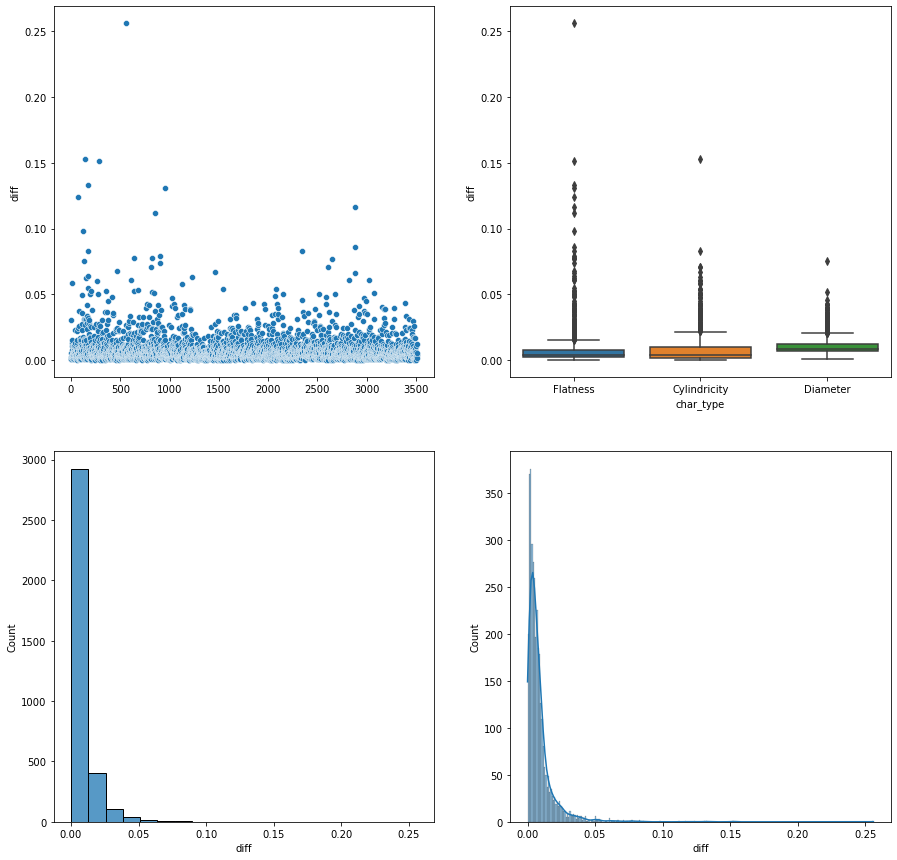

In [7]:
"""
Quick visualizations of unfiltered data: difference between repeated measurements

"""

# Initiate figure
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))

# PLOT 1: Scatterplot for all differences
sns.scatterplot(data=df_tot['diff'], ax=axs[0][0])

# PLOT 2: Boxplot of the three characteristics
sns.boxplot(data=df_tot, x='char_type', y='diff', ax=axs[0][1])

# PLOT 3: Coarse histogram (20 bins)
sns.histplot(data=df_tot['diff'], bins=20, ax=axs[1][0])

# PLOT 4: Fine histogram with an overlay of kernel density estimation
sns.histplot(data=df_tot['diff'], kde=True, ax=axs[1][1])


# Display plots
plt.show()

In [8]:
# Statistical description of the flatness characteristic

df_tot[df_tot['char_type'] == 'Flatness'].describe()

,rep1,rep2,rep3,mean,diff
count,1620.000000,1620.000000,1620.000000,1620.000000,1620.000000
mean,0.095674,0.092236,0.090478,0.092796,0.007512
std,0.036275,0.032351,0.030264,0.032391,0.013618
min,0.050202,0.048980,0.050167,0.050770,0.000022
25%,0.073965,0.072598,0.071659,0.073202,0.002243
50%,0.085891,0.083702,0.082542,0.084008,0.004110
75%,0.104428,0.101005,0.099895,0.101750,0.007575
max,0.452250,0.379740,0.369438,0.400476,0.256032


In [9]:
# Statistical description of the cylindricity characteristic

df_tot[df_tot['char_type'] == 'Cylindricity'].describe()

,rep1,rep2,rep3,mean,diff
count,945.000000,945.000000,945.000000,945.000000,945.000000
mean,0.168441,0.163762,0.161195,0.164466,0.008281
std,0.090416,0.087664,0.085764,0.087803,0.011988
min,0.061079,0.059637,0.058774,0.060130,0.000037
25%,0.101745,0.098606,0.097388,0.099101,0.001853
50%,0.139948,0.134721,0.133477,0.135979,0.003870
75%,0.209945,0.203902,0.199819,0.204689,0.009673
max,0.626687,0.576267,0.542467,0.559931,0.152833


In [10]:
# Statistical description of the diameter characteristic

df_tot[df_tot['char_type'] == 'Diameter'].describe()

,rep1,rep2,rep3,mean,diff
count,945.000000,945.000000,945.000000,945.000000,945.000000
mean,-0.003456,-0.006173,-0.007973,-0.005867,0.010911
std,0.173366,0.168763,0.166170,0.169378,0.007351
min,-0.544659,-0.540020,-0.537463,-0.540714,0.000601
25%,-0.104839,-0.105265,-0.106002,-0.105763,0.006737
50%,-0.003160,-0.005236,-0.007362,-0.005159,0.008758
75%,0.100728,0.091944,0.087936,0.093160,0.012221
max,0.552522,0.529453,0.504446,0.519717,0.075344


---

## Filter data

---

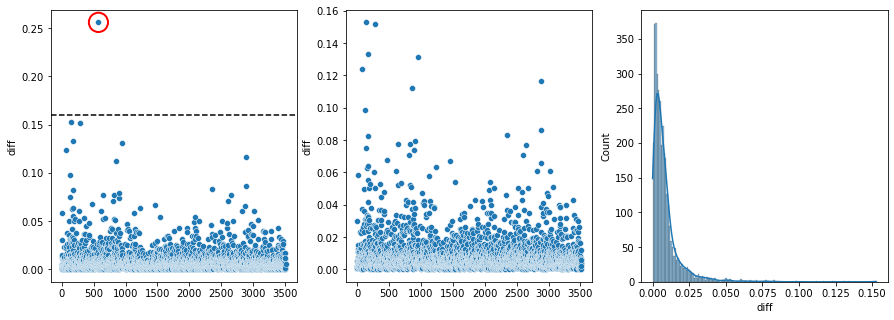

In [11]:
"""
Filter out the single extreme outlier of flatness (>0.25)

"""

# Determine threshold
lim = df_tot['diff'].max()

# Initiate figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


## PLOT 1: Show the datapoint being filtered out
# Scatterplot with Seaborn
sns.scatterplot(data=df_tot['diff'], ax=ax[0])

# Create and add the circle
circle = Ellipse(xy=(575, 0.256032), width=300, height=0.02, linewidth=2, color='red', fill=False)
ax[0].add_artist(circle)

# Indicate the limits of the next plot
ax[0].axhline(y=0.16, color='black', linestyle='--')


## Filter out the outlier
# Create new dataframe without the outlier
df_1 = df_tot[df_tot['diff'] < lim]


## PLOT 2: Scatterplot after filtering
sns.scatterplot(ax=ax[1], data=df_1['diff'])


## PLOT 3: Histogram with kernel density estimation after filtering
sns.histplot(ax=ax[2], data=df_1['diff'], kde=True)


# Display plot
plt.show()

Threshold: 0.1 mm
Number of filtered points: 8 (0.002 %)


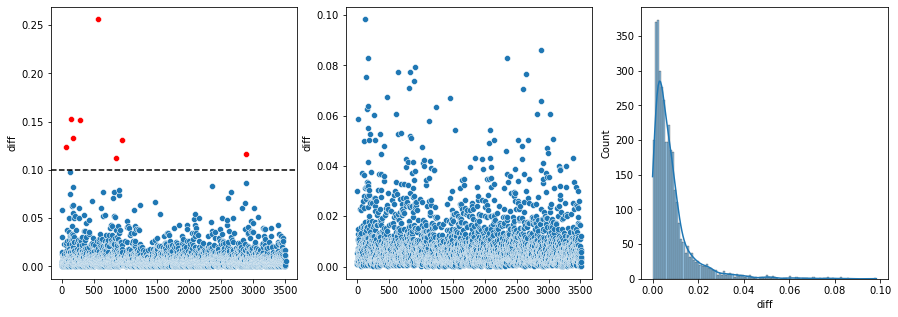

In [12]:
"""
Filter out all data where the difference is larger than 0.1 mm.

"""

## Filter out the outlier
# Determine threshold
lim = 0.1

# Print threshold
print("Threshold: {} mm".format(lim))

# Create new dataframe without the outlier
df_2 = df_tot[df_tot['diff'] < lim]


# Initiate figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


## PLOT 1: Show the datapoints being filtered out
# Scatterplot showing the remaining data
sns.scatterplot(data=df_2['diff'], ax=ax[0])

# Plot the filtered data with red dots in the same plot
sns.scatterplot(data=df_tot[df_tot['diff'] > lim]['diff'], ax=ax[0], color='red')

# Indicate the limits of the next plot
ax[0].axhline(y=lim, color='black', linestyle='--')


## PLOT 2: Scatterplot after filtering
sns.scatterplot(ax=ax[1], data=df_2['diff'])


## PLOT 3: Histogram with kernel density estimation after filtering
sns.histplot(ax=ax[2], data=df_2['diff'], kde=True)


# Determine the number of filtered points
count = len(df_tot[df_tot['diff'] > lim])

# Print the number of filtered points and the ratio
print("Number of filtered points: {} ({:.3f} %)".format(count, count/len(df_tot)))


# Display plots
plt.show()

Threshold: 0.05 mm
Number of filtered points: 47 (0.013 %)


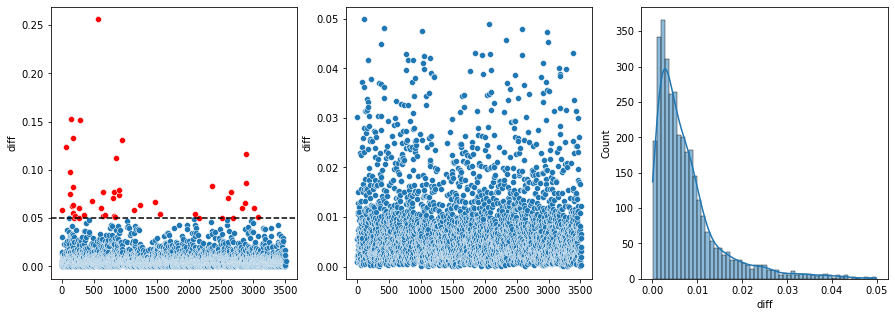

In [13]:
"""
Filter out all data where the difference is larger than 0.05 mm.

"""

## Filter out the outlier
# Determine threshold
lim = 0.05

# Print threshold
print("Threshold: {} mm".format(lim))

# Create new dataframe without the outlier
df_3 = df_tot[df_tot['diff'] < lim]


# Initiate figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


## PLOT 1: Show the datapoints being filtered out
# Scatterplot showing the remaining data
sns.scatterplot(data=df_3['diff'], ax=ax[0])

# Plot the filtered data with red dots in the same plot
sns.scatterplot(data=df_tot[df_tot['diff'] > lim]['diff'], ax=ax[0], color='red')

# Indicate the limits of the next plot
ax[0].axhline(y=lim, color='black', linestyle='--')


## PLOT 2: Scatterplot after filtering
sns.scatterplot(ax=ax[1], data=df_3['diff'])


## PLOT 3: Histogram with kernel density estimation after filtering
sns.histplot(ax=ax[2], data=df_3['diff'], kde=True)


# Determine the number of filtered points
count = len(df_tot[df_tot['diff'] > lim])

# Print the number of filtered points and the ratio
print("Number of filtered points: {} ({:.3f} %)".format(count, count/len(df_tot)))


# Display plots
plt.show()

Threshold: 0.044 mm
Number of filtered points: 56 (0.016 %)


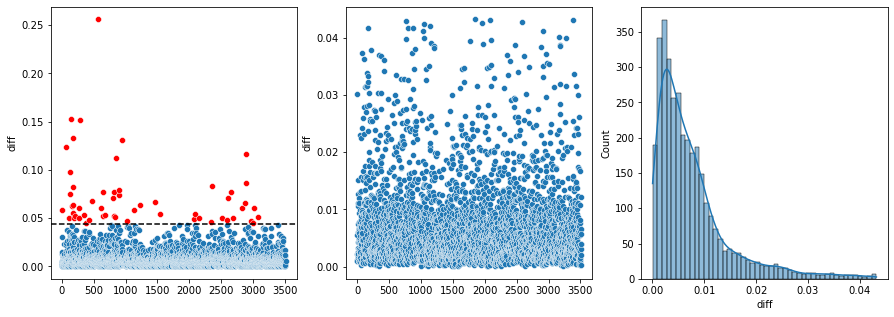

In [14]:
"""
Filter out all data where the difference is larger than three standard deviations from the mean.

"""

## Filter out the outlier
# Determine threshold
lim = df_tot['diff'].mean() + 3*(df_tot['diff'].std())

# Print threshold
print("Threshold: {:.3f} mm".format(lim))

# Create new dataframe without the outlier
df_4 = df_tot[df_tot['diff'] < lim]


# Initiate figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))


## PLOT 1: Show the datapoints being filtered out
# Scatterplot showing the remaining data
sns.scatterplot(data=df_4['diff'], ax=ax[0])

# Plot the filtered data with red dots in the same plot
sns.scatterplot(data=df_tot[df_tot['diff'] > lim]['diff'], ax=ax[0], color='red')

# Indicate the limits of the next plot
ax[0].axhline(y=lim, color='black', linestyle='--')


## PLOT 2: Scatterplot after filtering
sns.scatterplot(ax=ax[1], data=df_4['diff'])


## PLOT 3: Histogram with kernel density estimation after filtering
sns.histplot(ax=ax[2], data=df_4['diff'], kde=True)


# Determine the number of filtered points
count = len(df_tot[df_tot['diff'] > lim])

# Print the number of filtered points and the ratio
print("Number of filtered points: {} ({:.3f} %)".format(count, count/len(df_tot)))


# Display plots
plt.show()

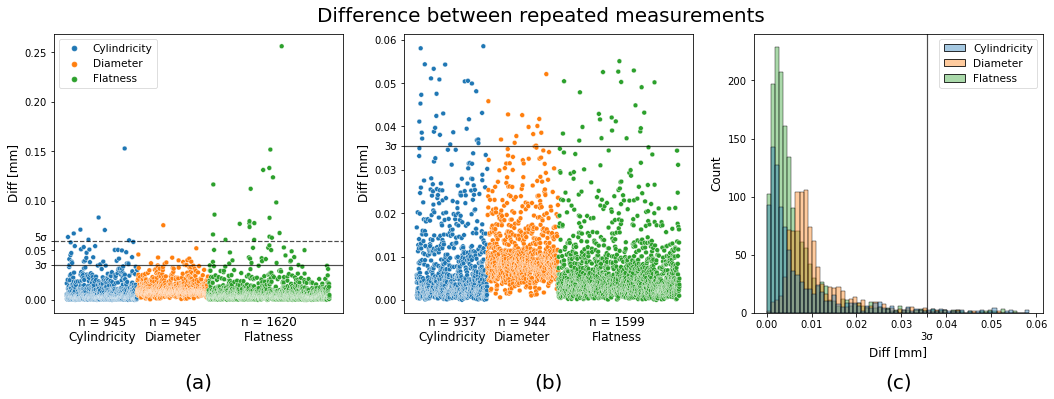

In [15]:
"""
Plotting the difference between repeated measurements based on the characteristic type

"""

# Definition for font size
small = 12
large = 20

# Initialize figure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Configure layout spacing
fig.tight_layout(pad=3.0)

# Set context with Seaborn
sns.set_context("paper", font_scale=1.2)

# Set figure title
fig.suptitle("Difference between repeated measurements", fontsize='xx-large')

## Prepare data
# Create new dataframe sorted by characteristic type
data = df_tot.sort_values(by='char_type')

# Compute the standard deviation of differences
std = df_tot['diff'].std()

# Reset index
data.reset_index(drop=True, inplace=True)

##########################################################

## PLOT 1
# Scatterplot in first frame
sns.scatterplot(ax=ax[0], data=data, y='diff', x=data.index, hue='char_type', legend=True)

# Insert horizontal line at three standard deviations
ax[0].axhline(y=std*3, color='black', linestyle='-', alpha=0.7)

# Insert horizontal line at five standard deviations
ax[0].axhline(y=std*5, color='black', linestyle='--', alpha=0.7)

# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
ax[0].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
ax[0].set_xticklabels(["n = {}\nCylindricity".format(n_cyl),\
                       "n = {}\nDiameter".format(n_dia),\
                       "n = {}\nFlatness".format(n_flt)], fontsize=small)

# Hide ticks on x-axis
ax[0].tick_params(axis='x', length=0)

# Set label for y-axis
ax[0].set_ylabel("Diff [mm]", fontsize=small)

# Set ticks on y-axis
ax[0].set_yticks([0, std*3, 0.05, std*5, 0.1, 0.15, 0.2, 0.25])

# Set tick labels for y-axis
ax[0].set_yticklabels(["0.00", "3\u03C3", "0.05", "5\u03C3\n", "0.10", "0.15", "0.20", "0.25"])

# Place legend in upper left corner without title
ax[0].legend(loc='upper left', title=None)

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(a)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[0].transAxes)


## Filter outliers above five standard deviations
data = data[data['diff'] < std * 5]

##########################################################

## PLOT 2
# Scatterplot in second frame
sns.scatterplot(ax=ax[1], data=data, y='diff', x=data.index, hue='char_type', legend=False)

# Insert horizontal line at three standard deviations
ax[1].axhline(y=std*3, color='black', linestyle='-', alpha=0.7)

# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
ax[1].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
ax[1].set_xticklabels(["n = {}\nCylindricity".format(n_cyl),\
                       "n = {}\nDiameter".format(n_dia),\
                       "n = {}\nFlatness".format(n_flt)], fontsize=small)

# Hide ticks on x-axis
ax[1].tick_params(axis='x', length=0)

# Set label for y-axis
ax[1].set_ylabel("Diff [mm]", fontsize=small)

# Set ticks on y-axis
ax[1].set_yticks([0, 0.01, 0.02, 0.03, std*3, 0.04, 0.05, 0.06])

# Set tick labels for y-axis
ax[1].set_yticklabels(["0.00", "0.01", "0.02", "0.03", "3\u03C3", "0.04", "0.05", "0.06"])

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(b)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[1].transAxes)

##########################################################

## PLOT 3
# Histogram in third frame
g = sns.histplot(ax=ax[2], data=data, x='diff', hue='char_type', alpha=0.4, kde=False, legend=True)

# Insert Vertical line at three standard deviations
ax[2].axvline(x=std*3, color='black', linestyle='-', alpha=0.7)

# Set label for x-axis
ax[2].set_xlabel("Diff [mm]", fontsize=small)

# Set ticks on x-axis
ax[2].set_xticks([0, 0.01, 0.02, 0.03, std*3, 0.04, 0.05, 0.06])

# Set tick labels for x-axis
ax[2].set_xticklabels(["0.00", "0.01", "0.02", "0.03", "\n3\u03C3", "0.04", "0.05", "0.06"])

# Set label for y-axis
ax[2].set_ylabel("Count", fontsize=small)

# Remove legend title
leg = ax[2].get_legend()
leg.set_title(None)

# Add letter below plot
plt.text(x=0.5, y=-0.25, s="(c)", fontsize=large,
         horizontalalignment='center',
         verticalalignment='center',
         transform=ax[2].transAxes)

# Save figure
# plt.savefig("plots/30_Difference_between_repeated_measurements.jpg", dpi=300, bbox_inches='tight')

## Display plot
plt.show()

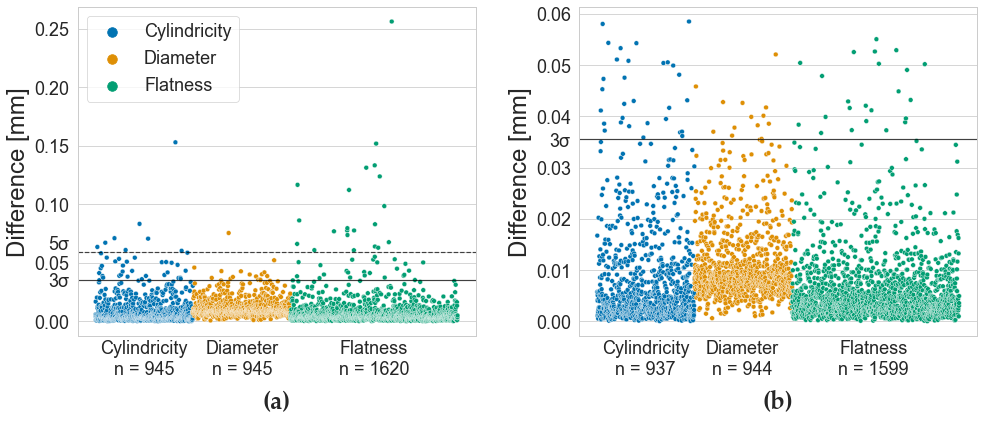

In [16]:
"""
Plot the difference between repeated measurements based on the characteristic type

Figures designed for publication in Applied Sciences

"""

# Seaborn theme
sns.set_theme(context='paper', style='whitegrid')

# Definition for font size
large = 24
medium = 18
small = 14
x_small = 12

# Define font
pfont = {'fontname':'Palatino Linotype'}

# Initialize figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

# Configure layout spacing
fig.tight_layout(pad=8.0)

# Set context with Seaborn
sns.set_context("paper", font_scale=1.2)


## Prepare data
# Create new dataframe sorted by characteristic type
data = df_tot.sort_values(by='char_type')

# Compute the standard deviation of differences
std = df_tot['diff'].std()

# Reset index
data.reset_index(drop=True, inplace=True)


## PLOT 1
# Scatterplot in first frame
sns.scatterplot(ax=axs[0], data=data, y='diff', x=data.index, hue='char_type', legend=True, palette='colorblind')

# Insert horizontal line at five standard deviations
axs[0].axhline(y=std*5, color='black', linestyle='--', alpha=0.7)

# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
axs[0].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
axs[0].set_xticklabels(["Cylindricity\nn = {}".format(n_cyl),\
                       "Diameter\nn = {}".format(n_dia),\
                       "Flatness\nn = {}".format(n_flt)], fontsize=medium)

# Set ticks on y-axis
axs[0].set_yticks([0, std*3, 0.05, std*5, 0.1, 0.15, 0.2, 0.25])

# Set tick labels for y-axis
axs[0].set_yticklabels(["0.00", "3\u03C3", "0.05", "5\u03C3\n", "0.10", "0.15", "0.20", "0.25"], fontsize=medium)

# Place legend in upper left corner without title
axs[0].legend(loc='upper left', title=None, fontsize=medium, fancybox=True, markerscale=2)

# Add letter below plot
plt.text(x=0.5, y=-0.2, s="(a)", fontsize=large, weight='bold', **pfont,
         horizontalalignment='center',
         verticalalignment='center',
         transform=axs[0].transAxes)


## Filter outliers above five standard deviations
data = data[data['diff'] < std * 5]


## PLOT 2
# Scatterplot in second frame
sns.scatterplot(ax=axs[1], data=data, y='diff', x=data.index, hue='char_type', legend=False, palette='colorblind')


# Get number of datapoints for each characteristic
n_cyl = len(data[data['char_type'] == 'Cylindricity'])
n_dia = len(data[data['char_type'] == 'Diameter'])
n_flt = len(data[data['char_type'] == 'Flatness'])

# Set ticks on x-axis in intersections between characteristics
axs[1].set_xticks([n_cyl/2, n_cyl + (n_dia/2), len(data) - (n_flt/2)])

# Set tick labels for x-axis
axs[1].set_xticklabels(["Cylindricity\nn = {}".format(n_cyl),\
                       "Diameter\nn = {}".format(n_dia),\
                       "Flatness\nn = {}".format(n_flt)], fontsize=medium)

# Set ticks on y-axis
axs[1].set_yticks([0, 0.01, 0.02, 0.03, std*3, 0.04, 0.05, 0.06])

# Set tick labels for y-axis
axs[1].set_yticklabels(["0.00", "0.01", "0.02", "0.03", "3\u03C3", "0.04", "0.05", "0.06"], fontsize=medium)

# Add letter below plot
plt.text(x=0.5, y=-0.2, s="(b)", fontsize=large, weight='bold', **pfont,
         horizontalalignment='center',
         verticalalignment='center',
         transform=axs[1].transAxes)

for ax in axs:
    # Set label for y-axis
    ax.set_ylabel("Difference [mm]", fontsize=large)
    
    # Hide ticks on x-axis
    ax.tick_params(axis='x', length=0)
    
    # Insert horizontal line at three standard deviations
    ax.axhline(y=std*3, color='black', linestyle='-', alpha=0.7)
    
    # Set grid for y-axis only
    ax.xaxis.grid(False)

# Save figure
# plt.savefig("plots/30.4_Difference_between_repeated_measurements.jpg", dpi=300, bbox_inches='tight')

## Display plot
plt.show()

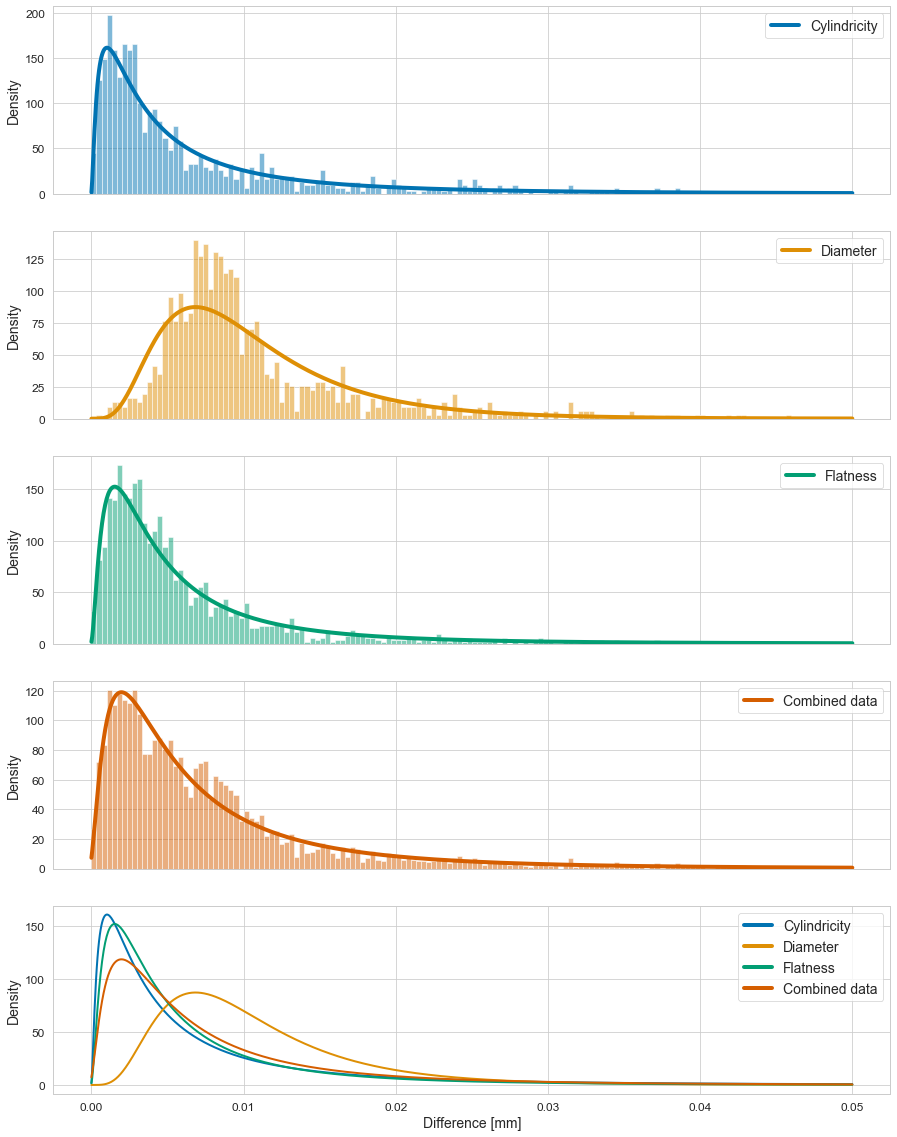

In [17]:
"""
Compare the distributions of difference between repeated measurements and fit the distribtions to
probability density function (log-normal distribution)

"""

## Define function for retrieving the frozen distribution
#  Valid distribution include lognorm, invgamma and powerlognorm
def calc_pdf(x, data):
    return stats.lognorm.pdf(x, *stats.lognorm.fit(data))


## Set parameters
# Seaborn theme
sns.set_theme(context='paper', style='whitegrid')

# Range for x-axis
xr = 0.05

# Array for x-axis
x = np.linspace(0, xr, 1000)

# Number of bins for histograms
b = 150

# Transperency for histograms
a = 0.5

# Define colors
colors = sns.color_palette('colorblind')

# Define the characteristics
chars = ["Cylindricity", "Diameter", "Flatness"]

# Definition for font size
large = 24
medium = 18
small = 14
x_small = 12


## Create figure
# Initialize a figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=True)

# Initialize legend
legend_elements = []


## Single characteristics
# Iterate all characteristics and plot them seperately
for char, i in zip(chars, range(3)):
    # Create histogram for the characteristic
    sns.histplot(df_tot.loc[df_tot['char_type'] == char, 'diff'], stat='density', bins=b, binrange=(0, xr), ax=axs[i], color=colors[i], alpha=a)

    # Find the probability density function for fitted lognormal distribution
    pdf = calc_pdf(x, df_tot.loc[df_tot['char_type'] == char, 'diff'])
    
    # Plot the fitted probability density function over the histogram
    sns.lineplot(x=x, y=pdf, ax=axs[i], linewidth=4, color=colors[i])
    
    # Plot fitted probability density function in the final panel
    sns.lineplot(x=x, y=pdf, ax=axs[4], linewidth=2, color=colors[i])
    
    
    ## Entry in legend
    # Define line with label for legend
    line = Line2D([0], [0], color=colors[i], lw=4, label=char)
    
    # Add legend for current panel
    axs[i].legend(handles=[line], loc='upper right', fontsize=small)
    
    # Add legend entry to the list of legend elements for the last panel
    legend_elements.append(line)
    

## Combined data
# Define line with label for legend
line = Line2D([0], [0], color=colors[3], lw=4, label='Combined data')

# Add legend for current panel
axs[3].legend(handles=[line], loc='upper right', fontsize=small)

# Add legend entry to the list of legend elements for the last panel
legend_elements.append(line)

# Plot the aggregated data as histogram
sns.histplot(df_tot['diff'], stat='density', bins=b, binrange=(0, xr), ax=axs[3], alpha=a, color=colors[3])

# Find the probability density function for fitted lognormal distribution
pdf = calc_pdf(x, df_tot['diff'])

# Plot the fitted probability density function over the histogram
sns.lineplot(x=x, y=pdf, ax=axs[3], linewidth=4, color=colors[3])

# Plot fitted probability density function in the final panel
sns.lineplot(x=x, y=pdf, ax=axs[4], linewidth=2, color=colors[3])

# Add legend to the last panel
axs[4].legend(handles=legend_elements, loc='upper right', fontsize=small)


# Deifne parameters common to all panels
for ax in axs:
    # Set label for the y-axis
    ax.set_ylabel("Density", fontsize=small)
    
    # Set label for the x-axis
    ax.set_xlabel("Difference [mm]", fontsize=small)
    
    # Set labelsizes
    ax.tick_params(labelsize=x_small)


# Save figure
# plt.savefig("plots/31.0_Difference_between_repeated_measurements.jpg", dpi=300, bbox_inches='tight')


## Display plot
plt.show()

---

## Quick collected view

---

In [18]:
"""
Define a dataframe of the relevant characteristics with repetition number as a single column

"""

# Specify characteristics
chars = ['Cylindricity_Cyl_4mm_Pos',
         'Cylindricity_Cyl_8mm_Neg',
         'Cylindricity_Cyl_8mm_Pos',
         'Cylindricity_Cyl_16mm-Neg',
         'Cylindricity_Cyl_16mm_Pos',
         'Cylindricity_Cyl_24mm_Neg',
         'Cylindricity_Cyl_24mm_Pos',
         'Diameter_Cyl_4mm_Pos',
         'Diameter_Cyl_8mm_Neg',
         'Diameter_Cyl_8mm_Pos',
         'Diameter_Cyl_16mm_Neg',
         'Diameter_Cyl_16mm_Pos',
         'Diameter_Cyl_24mm_Neg',
         'Diameter_Cyl_24mm_Pos',
         'Flatness_HX1_Plane1',
         'Flatness_HX1_Plane2',
         'Flatness_HX1_Plane3',
         'Flatness_HX1_Plane4',
         'Flatness_HX1_Plane5',
         'Flatness_HX1_Plane6',
         'Flatness_HX2_Plane1',
         'Flatness_HX2_Plane2',
         'Flatness_HX2_Plane3',
         'Flatness_HX2_Plane4',
         'Flatness_HX2_Plane5',
         'Flatness_HX2_Plane6']

# Withdraw the specified characteristics from the original dataframe
df_rep = df[df['char_name'].isin(chars)]

# Display the first five rows of the new dataframe
df_rep.head()

,part_name,rep,char_name,error,time,char_number
2,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_4mm_Pos,0.068728,2020-07-09 14:20:27,10
3,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Pos,0.090972,2020-07-09 14:20:27,8
4,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_16mm-Neg,0.098636,2020-07-09 14:20:27,6
5,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_24mm_Neg,0.112535,2020-07-09 14:20:27,4
12,Leirmo_Exp1_Build3_#11,3,Cylindricity_Cyl_8mm_Neg,0.066762,2020-07-09 14:20:27,19


In [19]:
# Give a brief description of the data in the new dataframe

df_rep.describe()

,rep,error,char_number
count,10530.000000,10530.000000,10530.000000
mean,2.000000,0.085529,43.384615
std,0.816535,0.119441,21.026765
min,1.000000,-0.544659,4.000000
25%,1.000000,0.066806,19.000000
50%,2.000000,0.087772,49.500000
75%,3.000000,0.128036,62.000000
max,3.000000,0.626687,68.000000


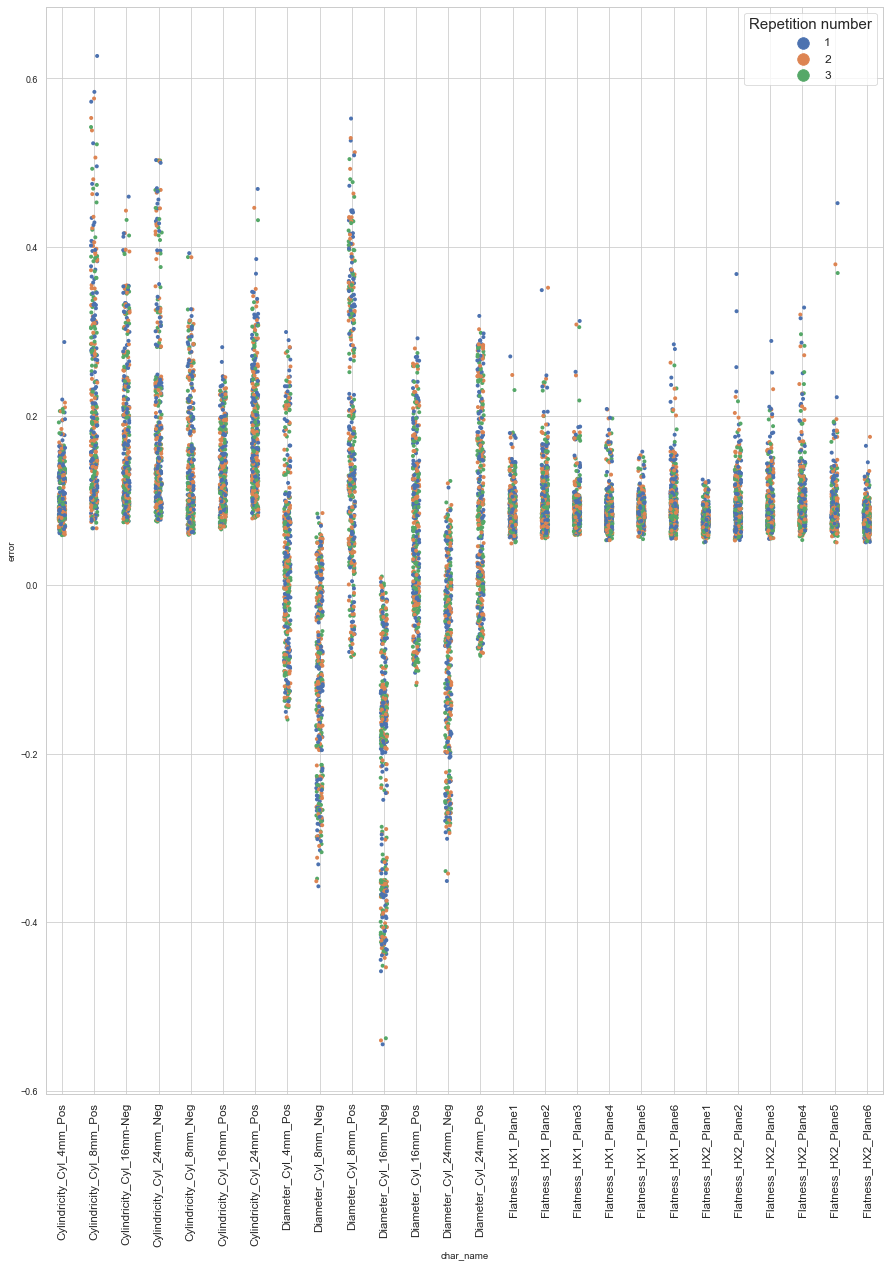

In [20]:
"""
Plot the measured error categorized by characteristics and mark repetition number

"""

# Initiate figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 20))

# Plot stripplot using Seaborn
sns.stripplot(data=df_rep, x='char_name', y='error', hue='rep', ax=ax, size=4)

# Rotate and enlarge labels
ax.tick_params(axis='x', labelsize='large', labelrotation=90)

# Add grid to x-axis to make categories clear
ax.grid(axis='x')

# Make legend easier to read by specifying size and title
ax.legend(title="Repetition number", title_fontsize=15, fontsize=12, markerscale=1.5)

# Display plot
plt.show()